In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import pyarrow.parquet as pq
import polars as pl
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from functions_analysis import *

In [3]:
#taking the mean of all meters for meteo_data
avg_Meteo('data/meteo_data.parquet', 'data/meteo_avg.parquet' )

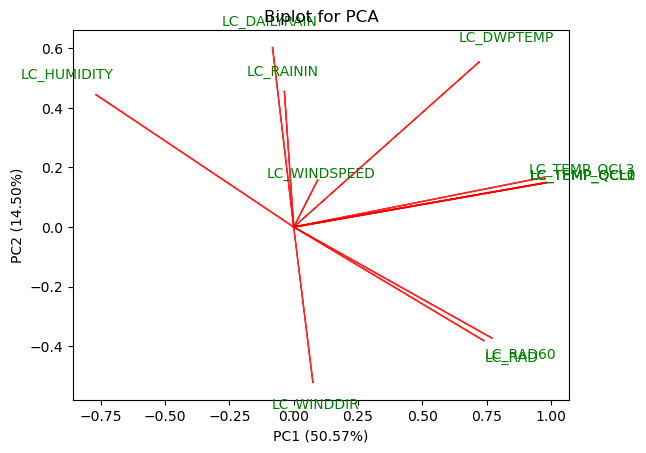

In [4]:
#Performing PCA on the averaged Meteo Data
PCA_meteo('data/meteo_avg.parquet', 'data/pca_comp.parquet')

In [5]:
pca_comp = pd.read_parquet('data/pca_comp.parquet')

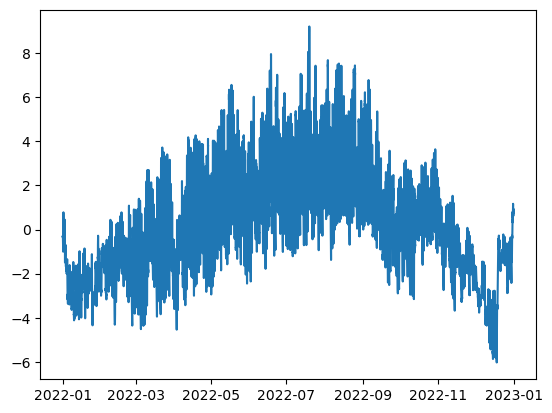

In [6]:
plt.plot(pca_comp['PC1'])

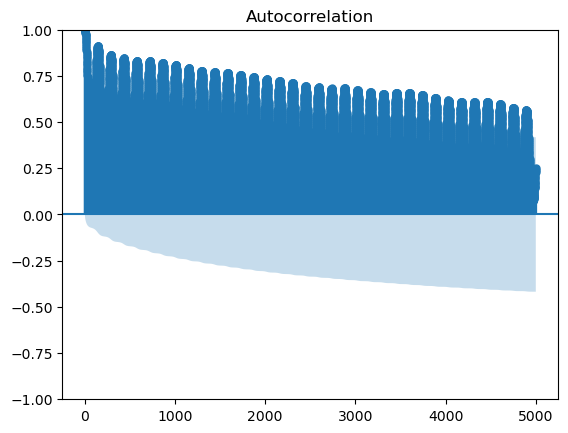

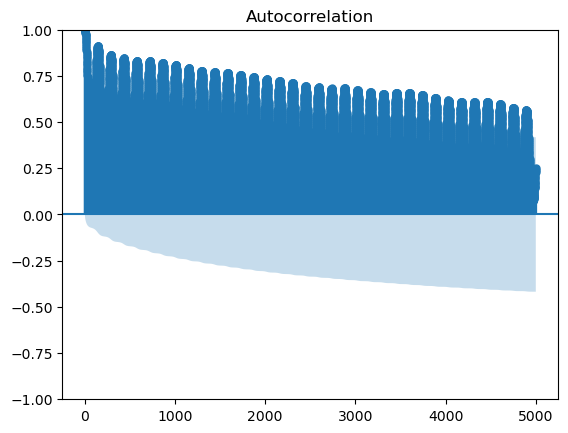

In [7]:
#Plot ACF of PCA Components to see if they are stationary
plot_acf(pca_comp['PC1'], lags=5000)

We can see high autocorrelation, this could be because of daily trend, so we do differencing in order to make the series stationary

In [8]:
differencing('data/pca_comp.parquet', 'PC1','PC1_diff1')

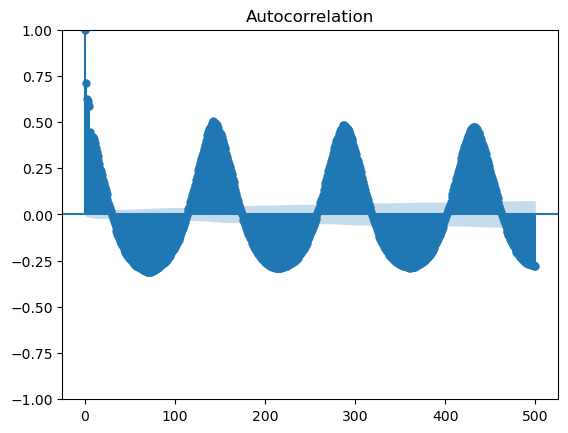

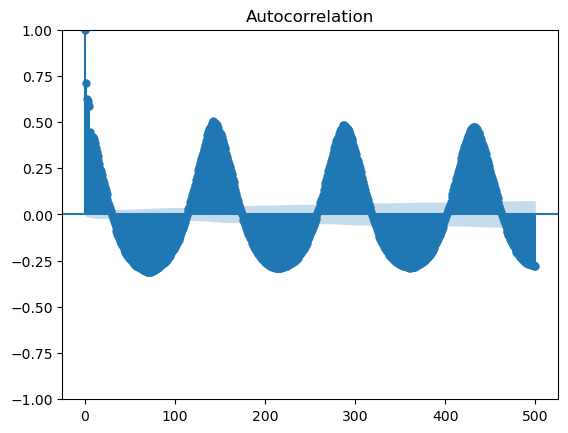

In [9]:
#check the acf of the first component again
pca_comp = pd.read_parquet('data/pca_comp.parquet')
plot_acf(pca_comp['PC1_diff1'], lags=500)

We can see that, now after differencing the PC1 once, there is some pattern still existing, at every 144th lag. This is because we have 10 minutes data, 144*10/60=24, which implies there is a seasonality every 24hrs. Now, we do differencing at lag 144, to get rid of this daily trend. 

In [10]:
differencing_144('data/pca_comp.parquet', 'PC1_diff1','PC1_diff1_144')

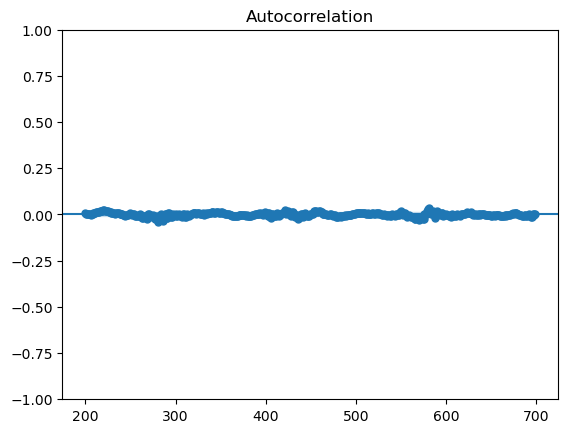

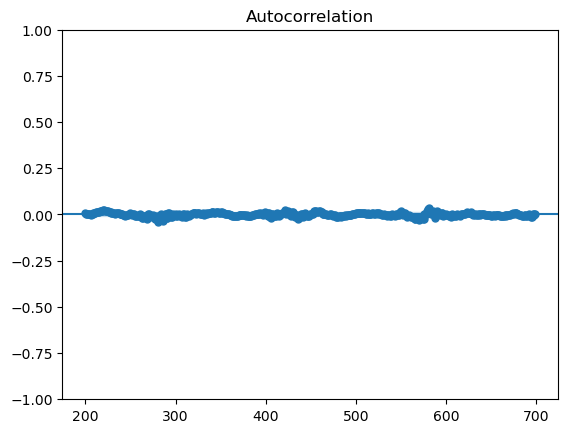

In [11]:
#check the acf of the first component after differencing at 144 lags
pca_comp = pd.read_parquet('data/pca_comp.parquet')
plot_acf(pca_comp['PC1_diff1_144'], lags=range(200, 700))

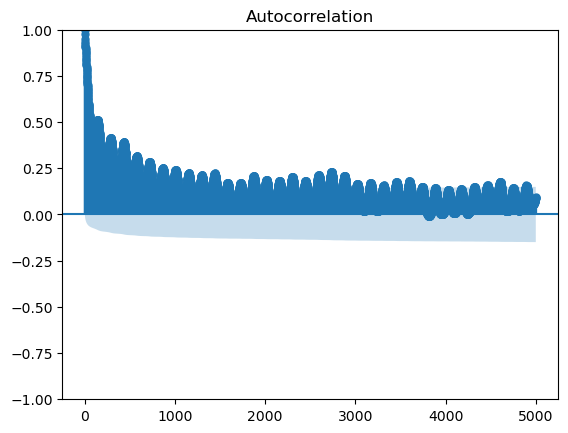

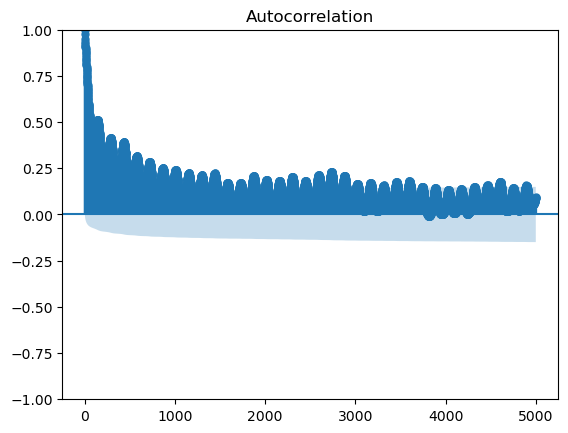

In [12]:
#we do the same for PC2
#Plot ACF of PCA Components to see if they are stationary
plot_acf(pca_comp['PC2'], lags=5000)

In [13]:
differencing('data/pca_comp.parquet', 'PC2','PC2_diff1')

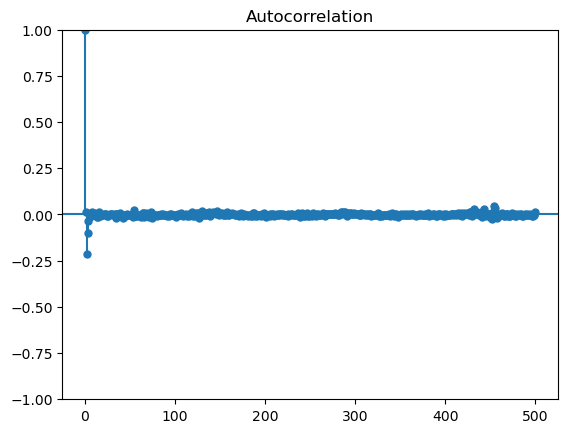

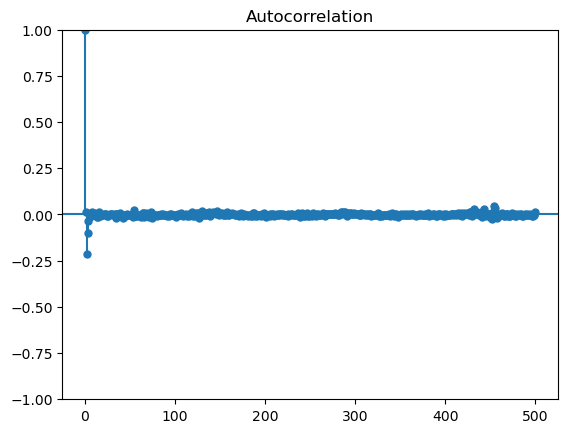

In [14]:
#check the acf of the secomd component after differencing
pca_comp = pd.read_parquet('data/pca_comp.parquet')
plot_acf(pca_comp['PC2_diff1'], lags=500)

This looks stationary, so no need of differencing again. This is because the most of the variance explained by the second component is by the variables such as LC_DailyRaining which do not have a daily pattern. 

In [15]:
#Test stationarity of the differenced components using ADFuller Test:
test_stationarity('data/pca_comp.parquet','PC1_diff1_144')

ADF statistic: -36.20711582362625
p-value: 0.0


In [16]:
test_stationarity('data/pca_comp.parquet','PC2_diff1')

ADF statistic: -37.37562928339401
p-value: 0.0


We can see that the p-value is 0, thus we reject the null of unit root, thus implying weak stationarity.

Now we use the minutes data of noise levels, convert them into 10 minutes data to have the same sampling period as the meteo data.

In [17]:
noise_resampling('data/noise_minutes.parquet','data/noise_resampled.parquet')

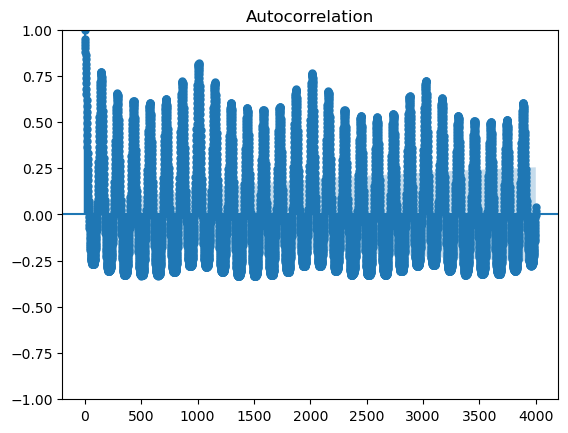

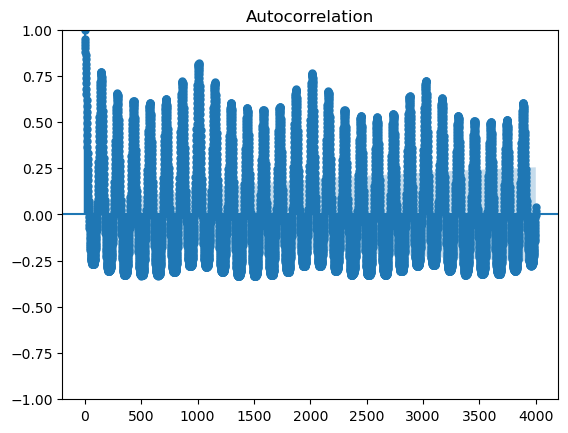

In [18]:
#We now look at the acf plot of laeq to see if it looks stationary
noise_resampled=pd.read_parquet('data/noise_resampled.parquet')
plot_acf(noise_resampled['laeq'], lags=4000) 

We can see that there is high autocorrelation and a trend in acf, so we do differencing and check the acf again

In [19]:
differencing('data/noise_resampled.parquet','laeq','laeq_diff1')
differencing('data/noise_resampled.parquet','lceq','lceq_diff1')
differencing('data/noise_resampled.parquet','lcpeak','lcpeak_diff1')
differencing('data/noise_resampled.parquet','lamax','lamax_diff1')

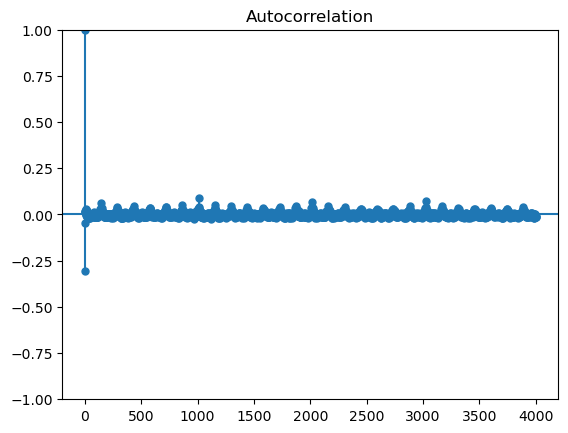

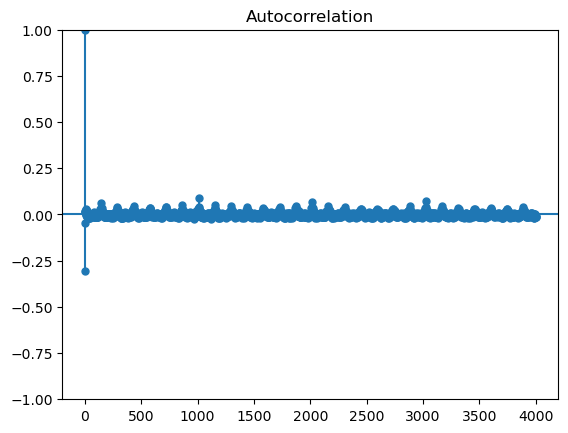

In [20]:
#We now look at the acf plot of laeq again to see if it looks stationary after differencing
noise_resampled=pd.read_parquet('data/noise_resampled.parquet')
plot_acf(noise_resampled['laeq_diff1'], lags=4000) 

We can see a few small peaks at every (approx 144 lags) few lags, thus implying some seasonality around lag 144, which is again due to the daily pattern which is repeated every 24 hrs. So we difference again with 144 lags.

In [21]:
differencing('data/noise_resampled.parquet','laeq_diff1','laeq_diff1_144')
differencing('data/noise_resampled.parquet','lceq_diff1','lceq_diff1_144')


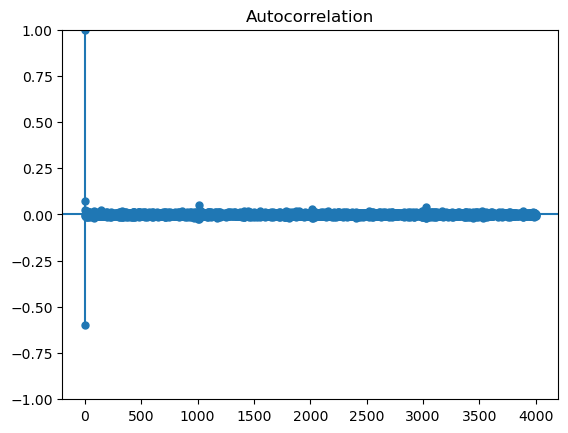

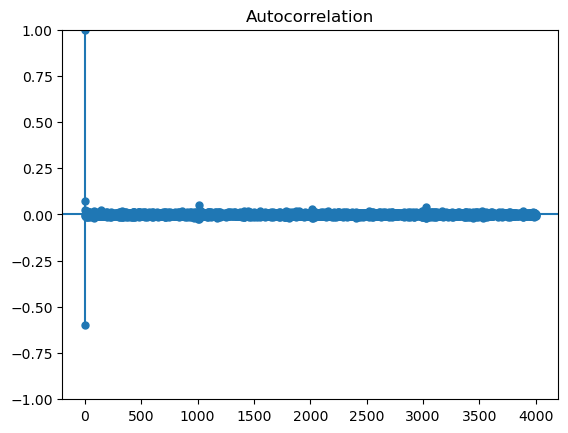

In [22]:
#We now look at the acf plot of laeq again to see if it looks stationary after differencing again
noise_resampled=pd.read_parquet('data/noise_resampled.parquet')
plot_acf(noise_resampled['laeq_diff1_144'], lags=4000)

Now that we have tried to remove the seasonality, we can test for stationarity using ADFuller Test

In [23]:
#Test stationarity of the differenced components using ADFuller Test:
test_stationarity('data/noise_resampled.parquet','laeq_diff1_144')

ADF statistic: -50.36679922204463
p-value: 0.0


In [24]:
test_stationarity('data/noise_resampled.parquet','lceq_diff1_144')

ADF statistic: -49.99401406490343
p-value: 0.0


We can see that both laeq, lceq have a 0 p-value, thus implying stationarity.
Since now we have both the meteo PCA data and noise data stationary and with the same sampling period(10 minutes), we can merge them using the index(date-time column).  

In [25]:
merge_noise_meteo('data/noise_resampled.parquet','data/meteo_avg.parquet','data/pca_comp.parquet','data/granger_merged.parquet')

Now we test for the granger causality of the stationary time series of the two principal components on laeq and lceq

In [26]:
test_granger_causality('data/granger_merged.parquet','PC1_diff1_144','laeq_diff1_144')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0999  , p=0.7519  , df_denom=52403, df_num=1
ssr based chi2 test:   chi2=0.0999  , p=0.7519  , df=1
likelihood ratio test: chi2=0.0999  , p=0.7519  , df=1
parameter F test:         F=0.0999  , p=0.7519  , df_denom=52403, df_num=1
Lag 1: p-value = 0.7519423593959026


In [27]:
test_granger_causality('data/granger_merged.parquet','PC2_diff1','laeq_diff1_144')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0074  , p=0.9313  , df_denom=52403, df_num=1
ssr based chi2 test:   chi2=0.0074  , p=0.9313  , df=1
likelihood ratio test: chi2=0.0074  , p=0.9313  , df=1
parameter F test:         F=0.0074  , p=0.9313  , df_denom=52403, df_num=1
Lag 1: p-value = 0.9312613278185056


In [28]:
test_granger_causality('data/granger_merged.parquet','PC1_diff1_144','lceq_diff1_144')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3423  , p=0.5585  , df_denom=52403, df_num=1
ssr based chi2 test:   chi2=0.3423  , p=0.5585  , df=1
likelihood ratio test: chi2=0.3423  , p=0.5585  , df=1
parameter F test:         F=0.3423  , p=0.5585  , df_denom=52403, df_num=1
Lag 1: p-value = 0.5585096033600878


In [29]:

test_granger_causality('data/granger_merged.parquet','PC2_diff1','lceq_diff1_144')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0330  , p=0.8559  , df_denom=52403, df_num=1
ssr based chi2 test:   chi2=0.0330  , p=0.8559  , df=1
likelihood ratio test: chi2=0.0330  , p=0.8559  , df=1
parameter F test:         F=0.0330  , p=0.8559  , df_denom=52403, df_num=1
Lag 1: p-value = 0.8558844453293553


We can see that all the p-values are above 0.05, thus we do not reject the null hypothesis of no granger causality. Therefore meteo data do not have a significant explanatory power in predicting laeq or lceq.

In [30]:
granger=pd.read_parquet('data/granger_merged.parquet')

In [31]:
granger[['lceq','laeq','PC1','PC2']].corr()

,lceq,laeq,PC1,PC2
lceq,1.000000,0.954657,0.320430,-0.060660
laeq,0.954657,1.000000,0.237627,-0.022885
PC1,0.320430,0.237627,1.000000,0.000117
PC2,-0.060660,-0.022885,0.000117,1.000000


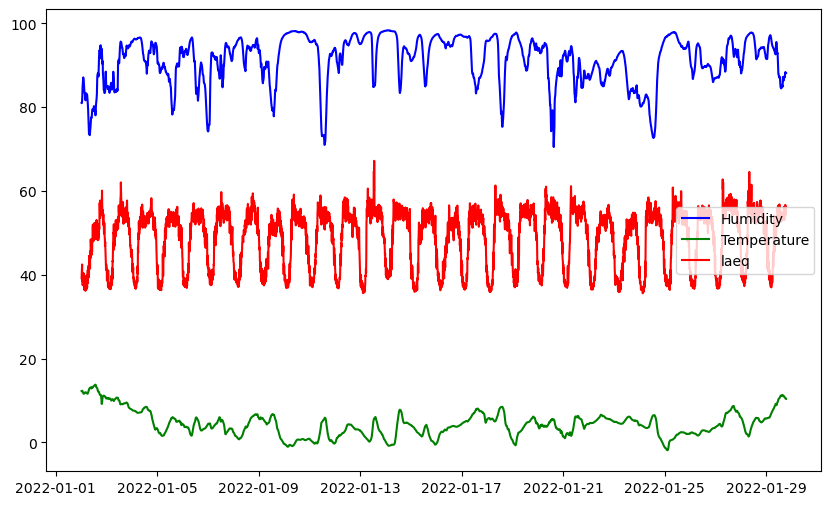

In [32]:
# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
# Plot the first graph in blue
ax.plot(granger['LC_HUMIDITY'][:4000], color='blue', label='Humidity')
ax.plot(granger['LC_TEMP_QCL3'][:4000], color='green', label='Temperature')

# Plot the second graph in red
ax.plot(granger['laeq'][:4000], color='red', label='laeq')

# Add legend
ax.legend()